In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



🧑 Showing facial expressions for: Aubert


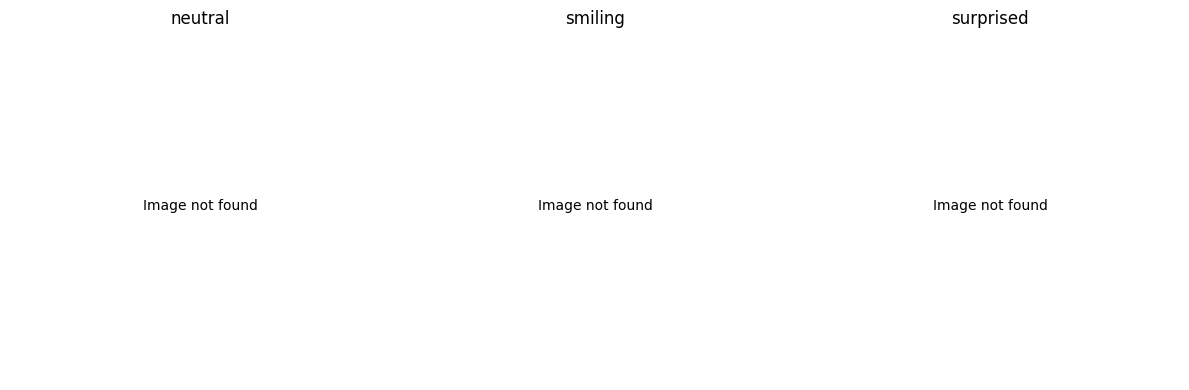


🧑 Showing facial expressions for: Jade


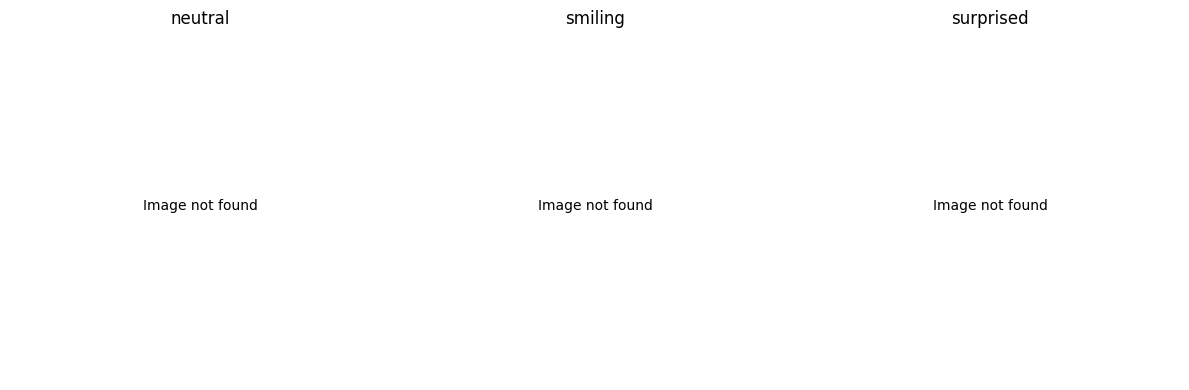


🧑 Showing facial expressions for: Liliane


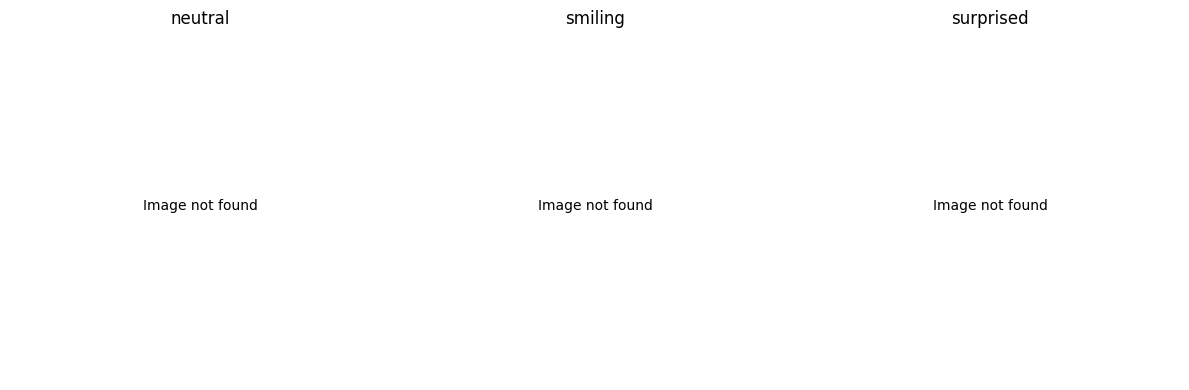


🧑 Showing facial expressions for: Pauline


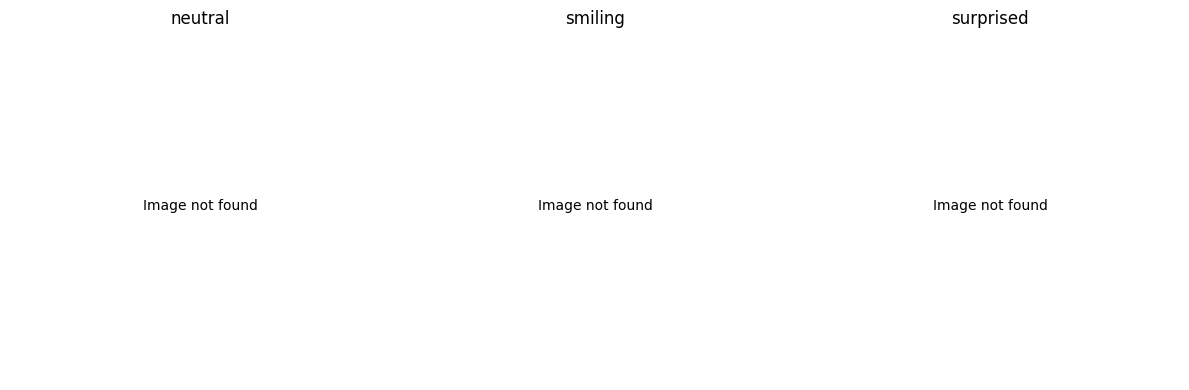

In [2]:
members = ['Aubert', 'Jade', 'Liliane', 'Pauline']
expressions = ['neutral', 'smiling', 'surprised']

def display_group_images():
    for member in members:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        print(f"\n🧑 Showing facial expressions for: {member}")
        for i, expression in enumerate(expressions):
            filename = f"{member}_{expression}.jpeg"
            if os.path.exists(filename):
                img = cv2.imread(filename)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axs[i].imshow(img)
                axs[i].set_title(f"{expression}", fontsize=12)
                axs[i].axis('off')
            else:
                axs[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
                axs[i].set_title(expression)
                axs[i].axis('off')
        plt.tight_layout()
        plt.show()

display_group_images()



🧑 Showing facial expressions for: Aubert
Missing: ['group_images/Aubert_neutral.jpg', 'group_images/Aubert_neutral.jpeg', 'group_images/Aubert_neutral.png']
Missing: ['group_images/Aubert_smiling.jpg', 'group_images/Aubert_smiling.jpeg', 'group_images/Aubert_smiling.png']
Missing: ['group_images/Aubert_surprised.jpg', 'group_images/Aubert_surprised.jpeg', 'group_images/Aubert_surprised.png']


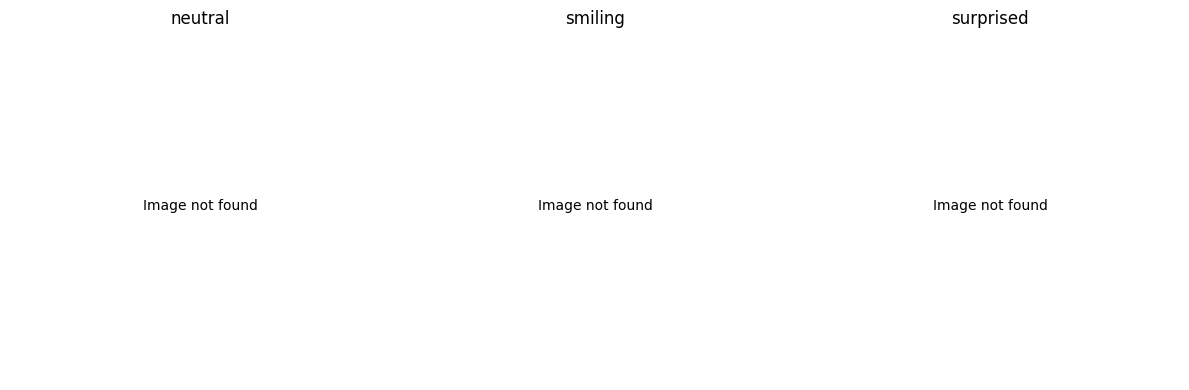


🧑 Showing facial expressions for: Jade


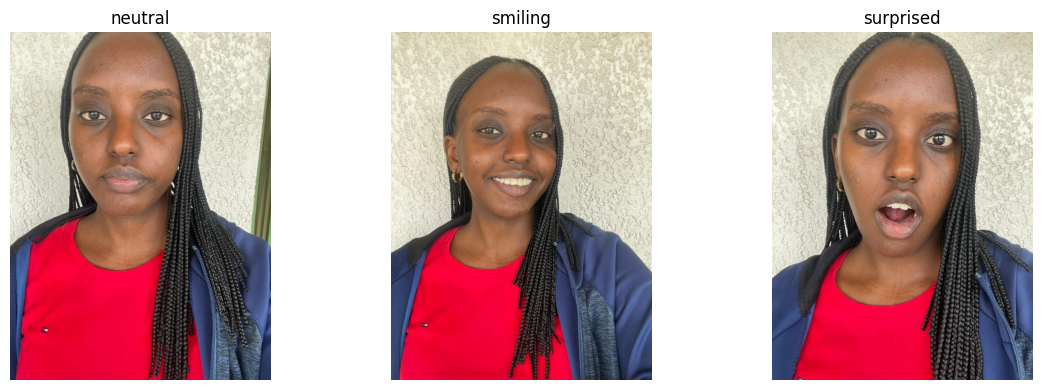


🧑 Showing facial expressions for: Liliane
Missing: ['group_images/Liliane_neutral.jpg', 'group_images/Liliane_neutral.jpeg', 'group_images/Liliane_neutral.png']
Missing: ['group_images/Liliane_smiling.jpg', 'group_images/Liliane_smiling.jpeg', 'group_images/Liliane_smiling.png']


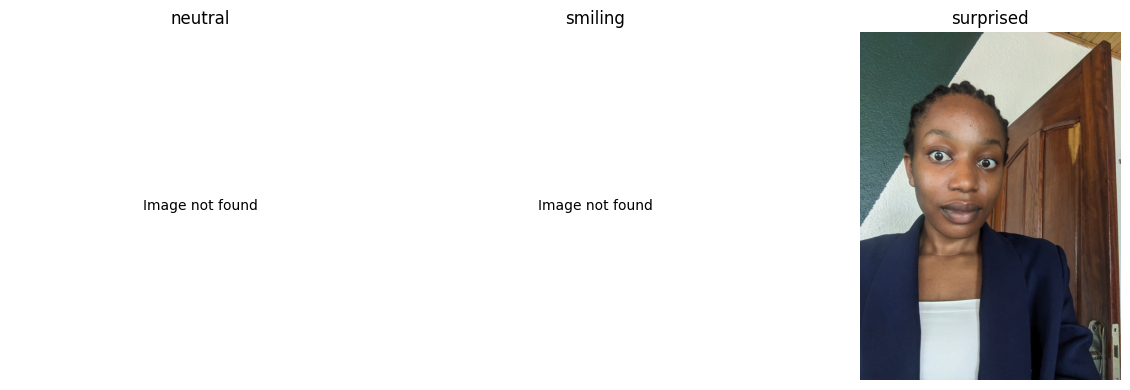


🧑 Showing facial expressions for: Pauline
Missing: ['group_images/Pauline_neutral.jpg', 'group_images/Pauline_neutral.jpeg', 'group_images/Pauline_neutral.png']
Missing: ['group_images/Pauline_surprised.jpg', 'group_images/Pauline_surprised.jpeg', 'group_images/Pauline_surprised.png']


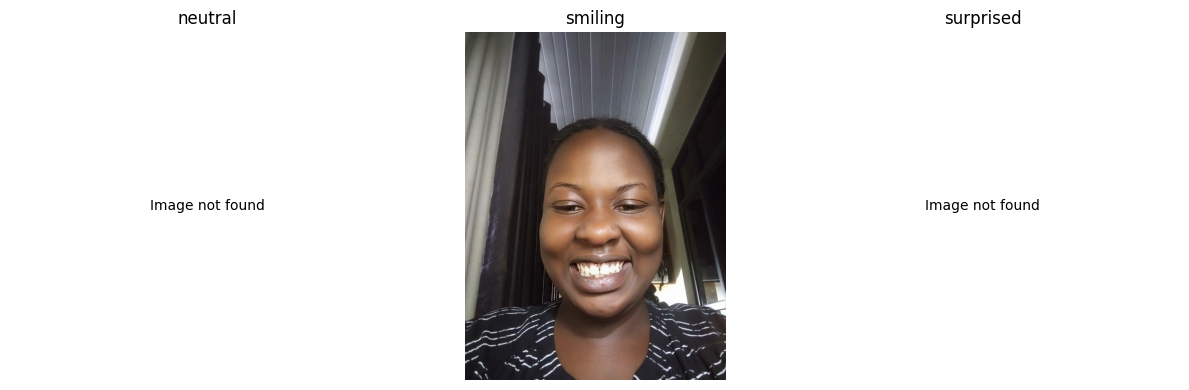

In [9]:
import gdown
import os
import cv2
import matplotlib.pyplot as plt

# Google Drive folder ID from your URL
folder_id = "1AiT2YsuPqUMPkU3Z6wilw8JrClkQAcy7"
url = f"https://drive.google.com/drive/folders/{folder_id}"

# # Create a directory for images
# os.makedirs("group_images", exist_ok=True)

# Download all files from the folder
# gdown.download_folder(url, output="group_images")

members = ['Aubert', 'Jade', 'Liliane', 'Pauline']
expressions = ['neutral', 'smiling', 'surprised']

def display_group_images():
    for member in members:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        print(f"\n🧑 Showing facial expressions for: {member}")
        for i, expression in enumerate(expressions):
            filename = [f"group_images/{member}_{expression}.jpg" ,f"group_images/{member}_{expression}.jpeg",f"group_images/{member}_{expression}.png"]
            for f in filename:
                if os.path.exists(f):
                    img = cv2.imread(f)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    axs[i].imshow(img)
                    axs[i].set_title(f"{expression}", fontsize=12)
                    axs[i].axis('off')
                    break
            else:
                print(f"Missing: {filename}")
                axs[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
                axs[i].set_title(expression)
                axs[i].axis('off')
        plt.tight_layout()
        plt.show()

display_group_images()